In [1]:
# citations of orignals:
# """
# first two attempts were DCGANs (result were mode collapse)
# MNIST DCGAN by TensorFlow Authors: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=ZBwyU6t2Wf3g
# Monet_ Dataset DCGAN architecture: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
# naming convention for models: https://github.com/thashimoto1998/DCGAN/blob/master/dcgan.py
#
# third attempt is WGAN-GP (better results)
# WGAN-GP video: https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
# WGAN-GP paper: https://arxiv.org/abs/1704.00028
# WGAN-GP github: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP
# """

In [2]:
###############################
###         Updates         ###
###############################

# added outputs folder to save GIFs

# for i in augmented_dataset:
#   i = i[0]


In [12]:
#############################
###    WGAN-GP Original    ###
#############################

In [3]:
import tensorflow as tf
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as transforms

In [6]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 32
image_size = 64
num_of_channels = 3
lambda_gradient_penalty = 10

latent_dim = 100
generator_features = 64

learning_rate = 1e-4
discriminator_features = 64
discriminator_iterations = 5

In [ ]:
!rm -r /content/ImageGeneration/ImageGeneration/
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

In [ ]:
# if this error:
# FileNotFoundError: Found no valid file [...] extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp
# then: make sure to not have image_at_epoch_0010.jpg in the folder

monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
dataloader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# show a sample
plt.imshow((monet_dataset[1][0][2]))
plt.axis('off')
plt.show()

In [ ]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  batch_size, C, H, W = real.shape
  epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [14]:
class Discriminator(nn.Module):
  def __init__(self, num_of_channels, discriminator_features):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(

      # Input Layer
      nn.Conv2d(num_of_channels, discriminator_features, kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(0.2),

      # Second Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features, discriminator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 2, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Third Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 2, discriminator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 4, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Fourth Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 4, discriminator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 8, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Output Layer is 4x4 (Conv2d turns into 1x1)
      nn.Conv2d(discriminator_features * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def forward(self, x):
    return self.discriminator(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim, num_of_channels, generator_features):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(

      #  Input Layer
      nn.Sequential(
        nn.ConvTranspose2d(latent_dim, generator_features * 16, kernel_size=4, stride=1, padding=0, bias=False,),
        nn.BatchNorm2d(generator_features * 16),
        nn.ReLU(),
      ),

      #  Second Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 16, generator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 8),
        nn.ReLU(),
      ),

      #  Third Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 8, generator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 4),
        nn.ReLU(),
      ),

      #  Fourth Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 4, generator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 2),
        nn.ReLU(),
      ),

      #  Output Layer
      nn.ConvTranspose2d(generator_features * 2, num_of_channels, kernel_size=4, stride=2, padding=1),
      nn.Tanh(),
  )

  def forward(self, x):
    return self.generator(x)

In [ ]:
def initialize_weights(model):
  for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
          nn.init.normal_(m.weight.data, 0.0, 0.02)

In [19]:
def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checpoint(checkpoint, generator, disc):
  print("=> Loading checkpoint")
  generator.load_state_dict(checkpoint['generator'])   # generator
  disc.load_state_dict(checkpoint['disciminator']) # discriminator

In [20]:
def wgan_generate_images():
  noise = tf.random.normal([batch_size, latent_dim])
  fake = generator(noise)
  return fake

def wgan_generate_and_plot_images():
  image = wgan_generate_images()
  generator_imgs = 0.5 * image + 0.5
  fig = plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(generator_imgs[i, :, :, :])
      plt.axis('off')
  plt.show()

In [30]:
generator = Generator(latent_dim, num_of_channels, generator_features).to(device)
discriminator = Discriminator(num_of_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(discriminator)

opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

step = 0

In [32]:
generator.train()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [33]:
discriminator.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [34]:
EPOCHS = 500

In [36]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/first_wgan

In [37]:
noise_dim = 100
num_examples_to_generate = 5

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

EPOCH [0/500] Batch 0/29 Loss D: -20.0647, loss G: 30.0081


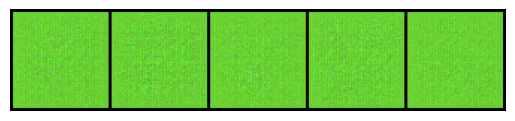

EPOCH [5/500] Batch 0/29 Loss D: -840.3026, loss G: 424.0958


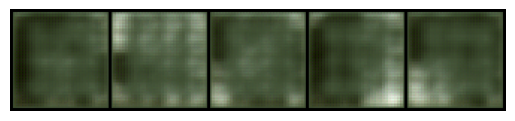

EPOCH [10/500] Batch 0/29 Loss D: -1730.6884, loss G: 878.2062


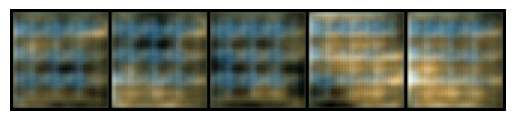

EPOCH [15/500] Batch 0/29 Loss D: -2357.7969, loss G: 1338.1641


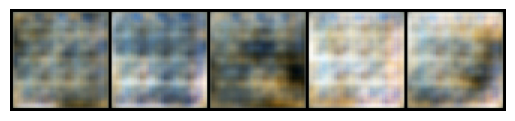

EPOCH [20/500] Batch 0/29 Loss D: -2427.1543, loss G: 1756.2761


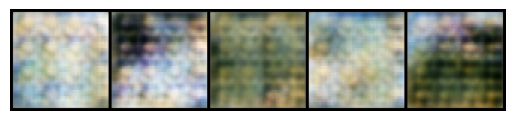

EPOCH [25/500] Batch 0/29 Loss D: -2630.8215, loss G: 2398.6499


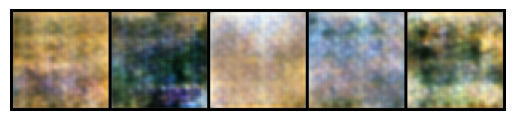

EPOCH [30/500] Batch 0/29 Loss D: -2842.5649, loss G: 2816.3013


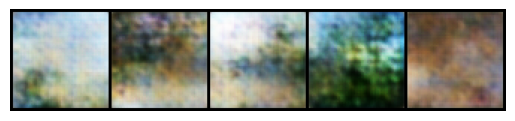

EPOCH [35/500] Batch 0/29 Loss D: -3287.0286, loss G: 3186.6919


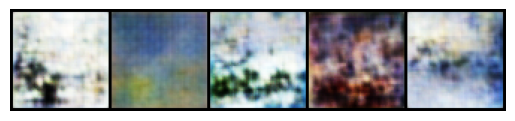

EPOCH [40/500] Batch 0/29 Loss D: -3733.5544, loss G: 1669.8481


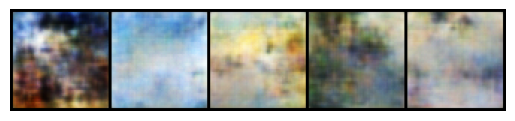

EPOCH [45/500] Batch 0/29 Loss D: -3671.6160, loss G: 4882.2832


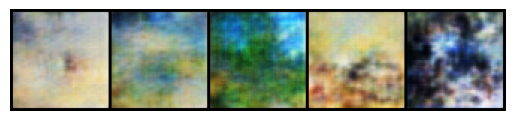

EPOCH [50/500] Batch 0/29 Loss D: -5503.7705, loss G: 5071.5986


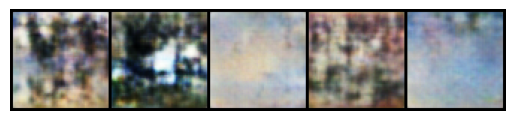

EPOCH [55/500] Batch 0/29 Loss D: -5646.9160, loss G: 5643.8086


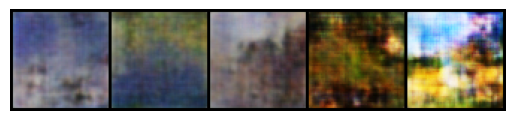

EPOCH [60/500] Batch 0/29 Loss D: -5513.0293, loss G: 6890.6084


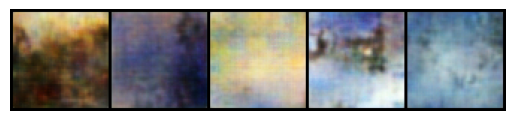

EPOCH [65/500] Batch 0/29 Loss D: -5489.3154, loss G: 7118.6440


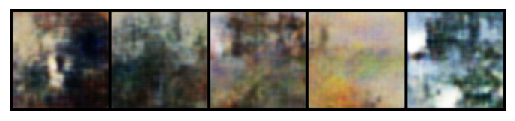

EPOCH [70/500] Batch 0/29 Loss D: -8656.5820, loss G: 7738.2842


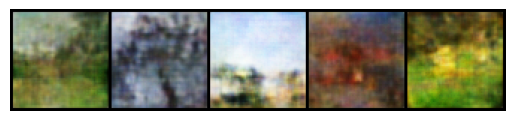

EPOCH [75/500] Batch 0/29 Loss D: -7099.6406, loss G: 7629.2422


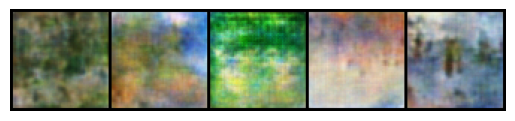

EPOCH [80/500] Batch 0/29 Loss D: -9189.4785, loss G: 7938.9268


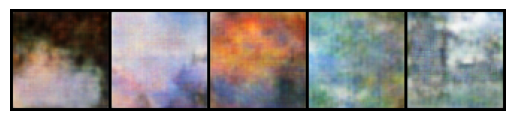

EPOCH [85/500] Batch 0/29 Loss D: -8333.3145, loss G: 10517.2812


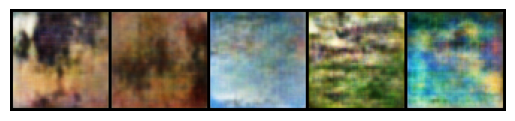

EPOCH [90/500] Batch 0/29 Loss D: -7890.3071, loss G: 6279.7593


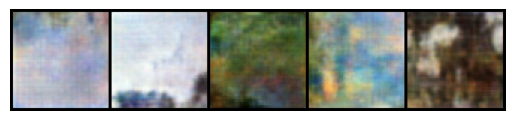

EPOCH [95/500] Batch 0/29 Loss D: -6518.5557, loss G: 8237.8691


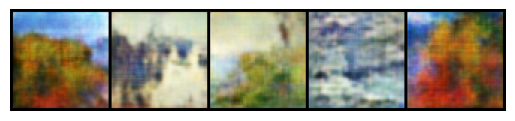

EPOCH [100/500] Batch 0/29 Loss D: -9732.6328, loss G: 12750.3203


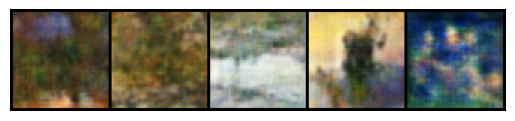

EPOCH [105/500] Batch 0/29 Loss D: -7887.3037, loss G: 14793.2070


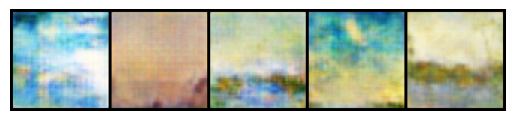

EPOCH [110/500] Batch 0/29 Loss D: -9604.3242, loss G: 9801.7139


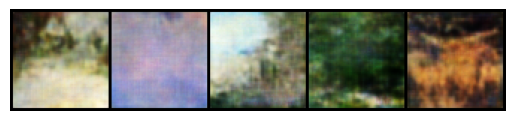

EPOCH [115/500] Batch 0/29 Loss D: -12386.5391, loss G: 12058.6914


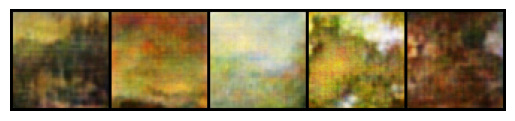

EPOCH [120/500] Batch 0/29 Loss D: -14424.7598, loss G: 13375.1133


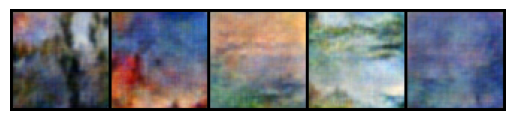

EPOCH [125/500] Batch 0/29 Loss D: -13743.5430, loss G: 16713.5098


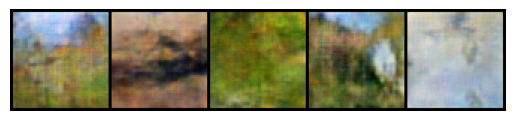

EPOCH [130/500] Batch 0/29 Loss D: -12253.7461, loss G: 18805.4316


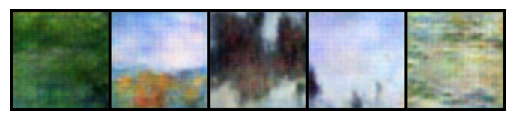

EPOCH [135/500] Batch 0/29 Loss D: -11990.2363, loss G: 13804.5986


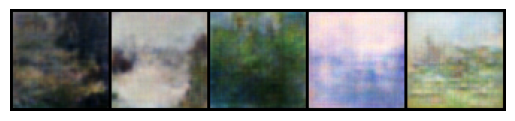

EPOCH [140/500] Batch 0/29 Loss D: -16046.6367, loss G: 17633.7812


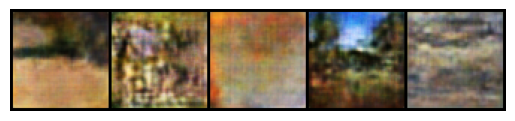

EPOCH [145/500] Batch 0/29 Loss D: -10580.8867, loss G: 14527.7119


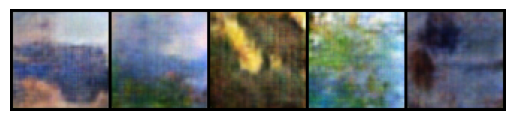

EPOCH [150/500] Batch 0/29 Loss D: -12390.3125, loss G: 17511.7695


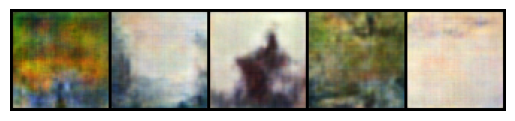

EPOCH [155/500] Batch 0/29 Loss D: -12963.8809, loss G: 24769.3555


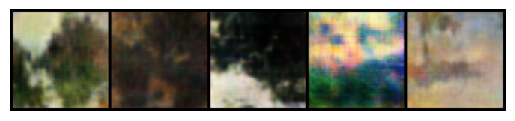

EPOCH [160/500] Batch 0/29 Loss D: -18451.6719, loss G: 20356.0098


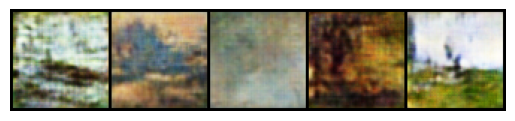

EPOCH [165/500] Batch 0/29 Loss D: -13280.0176, loss G: 17173.0000


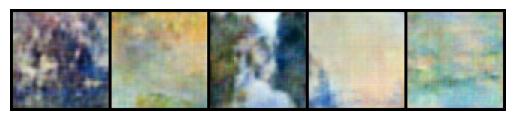

EPOCH [170/500] Batch 0/29 Loss D: -23226.1914, loss G: 23299.5449


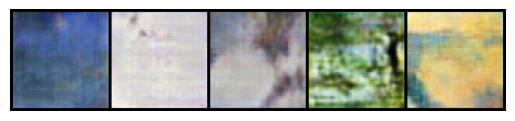

EPOCH [175/500] Batch 0/29 Loss D: -19953.5469, loss G: 28524.1211


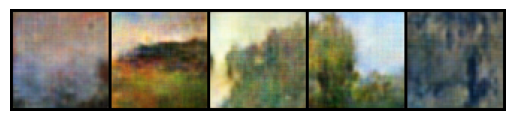

EPOCH [180/500] Batch 0/29 Loss D: -22578.7500, loss G: 27779.8184


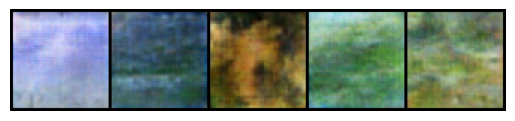

EPOCH [185/500] Batch 0/29 Loss D: -15671.9766, loss G: 30838.3828


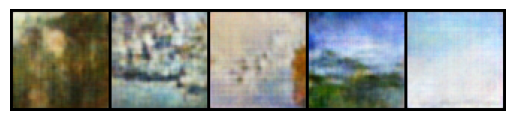

EPOCH [190/500] Batch 0/29 Loss D: -17293.3750, loss G: 32734.4531


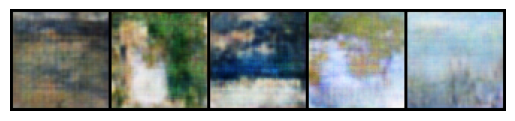

EPOCH [195/500] Batch 0/29 Loss D: -14986.3418, loss G: 20542.5020


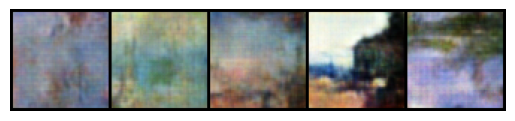

EPOCH [200/500] Batch 0/29 Loss D: -21838.7598, loss G: 29667.8828


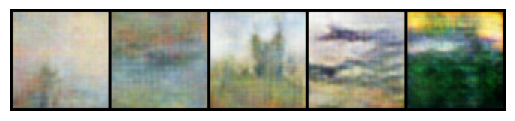

EPOCH [205/500] Batch 0/29 Loss D: -20443.1758, loss G: 30248.2500


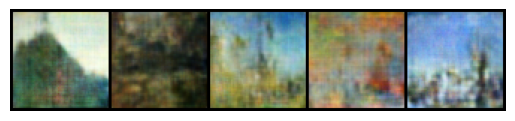

EPOCH [210/500] Batch 0/29 Loss D: -11866.0820, loss G: 33744.0000


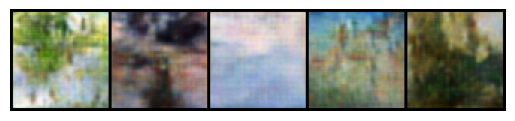

EPOCH [215/500] Batch 0/29 Loss D: -30005.0156, loss G: 39258.3047


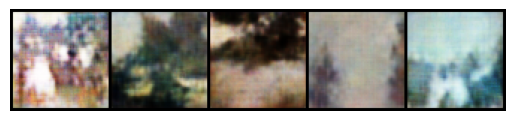

EPOCH [220/500] Batch 0/29 Loss D: -22492.5449, loss G: 32160.7480


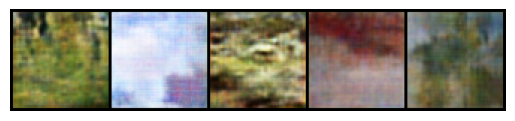

EPOCH [225/500] Batch 0/29 Loss D: -17251.5859, loss G: 36703.3438


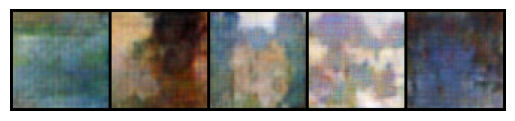

EPOCH [230/500] Batch 0/29 Loss D: -22575.5234, loss G: 33568.3281


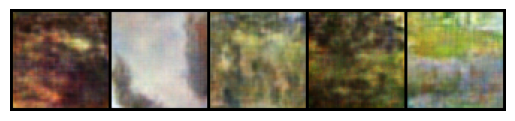

EPOCH [235/500] Batch 0/29 Loss D: -11010.5820, loss G: 38399.0742


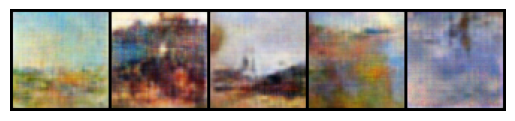

EPOCH [240/500] Batch 0/29 Loss D: -14969.7422, loss G: 38471.9336


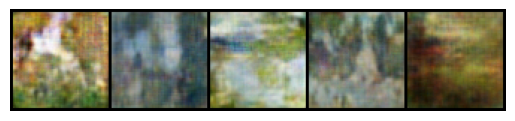

EPOCH [245/500] Batch 0/29 Loss D: -32917.1016, loss G: 45409.2578


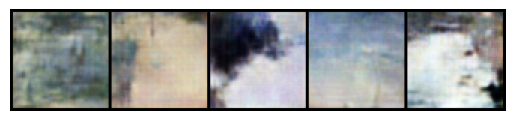

EPOCH [250/500] Batch 0/29 Loss D: -35838.0234, loss G: 41191.9766


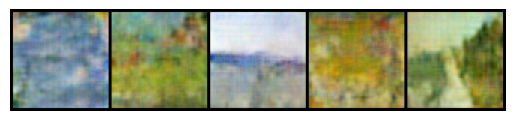

EPOCH [255/500] Batch 0/29 Loss D: -26722.6523, loss G: 43577.9688


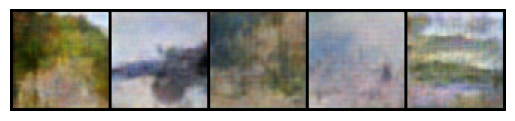

In [ ]:
#training

for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < 64: # sometimes had tensor of size 12
        break

    for _ in range(discriminator_iterations):
      noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
      fake = generator(noise)
      disc_real = discriminator(real).reshape(-1)
      disc_fake = discriminator(fake).reshape(-1)
      # print("real.shape: ", real.shape)
      # print("fake.shape: ", fake.shape)
      # print("disc(fake): ", disc(fake))
      gradient_pen = gradient_penalty(discriminator, real, fake, device=device)
      loss_discriminator = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gradient_penalty*gradient_pen
      )
      discriminator.zero_grad()
      loss_discriminator.backward(retain_graph=True)
      opt_discriminator.step()

    output = discriminator(fake).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics
    with torch.no_grad():
        img_grid_fake = torchvision.utils.make_grid(
          fake[:], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}"
          )
          plt.show()

    # generate with seed and save GIF
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/first_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/first_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
#############################
###    WGAN-GP Attempt    ###
#############################

In [ ]:
"""
latent dim 125
(grid output, vibrant colors) gen-layer 2048
gen-layer 1536 -> might be my output layer


change init dim?

rotated image gave decent results

batch to 48


bruh = functional.five_crop(img[0], 32)
"""

In [ ]:
""""
dataset = datasets.

- change cpu in gradient_penalty?
- different learning rates for disc, gen
- (didnt work, cuda runs out of memory) image size = 256, discriminator_featuresISC = 256, generator_featuresEN = 256
- batch 64 (less than 64 breaks break)
- if RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). \
    - resize image to 64


Attention Mechanisms: Used to focus on specific regions of the input, improving the quality of generated samples.
Generator: Transposed Convolutional (Deconvolutional) Layers: These layers “upsample” the data, allowing the generator to create higher-resolution images.
Discri Pooling Layers: Used to downsample feature maps, reducing spatial dimensions.



- padding = 2 # used to be 1
- kernel size = 5

init weights

Constrain Critic Weights:
After each mini-batch update, limit the critic model weights to a specific range (e.g., [-0.01, 0.01]).
This constraint prevents the critic from becoming too dominant and ensures stability during training.
"""

In [ ]:
import tensorflow as tf
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as transforms

In [ ]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

In [ ]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 32
image_size = 64
num_of_channels = 3
lambda_gradient_penalty = 10

discriminator_learning_rate = 1e-4
discriminator_features = 64
discriminator_iterations = 5

latent_dim = 100
generator_features = 64
generator_learning_rate = 5e-5

In [ ]:
!rm -r /content/ImageGeneration/ImageGeneration/
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

In [ ]:
# if FileNotFoundError: Found no valid file [...] extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp
# then: remove other non-image files including .git hidden folder (cell above)

to_tensor_transforms = transforms.Compose(
  [
    transforms.Resize(image_size),
    transforms.ToTensor(),
  ]
)

pix2tensor_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=to_tensor_transforms)

In [ ]:
!rm -r /content/augmented_images/monet/
!rm -r /content/augmented_images/

os.mkdir("/content/augmented_images")
os.mkdir("/content/augmented_images/monet")

to_pil_image = torchvision.transforms.ToPILImage()

counter = 0
for img in pix2tensor_dataset:
  five_images_cropped_from_one = functional.five_crop(img[0], 32)

  for new_img in five_images_cropped_from_one:
    # pil_image = to_pil_image(new_img)
    # pil_image = transforms(pil_image)
    pil_image = to_pil_image(new_img)

    pil_image.save('/content/augmented_images/monet/augmented_image_{:04d}.png'.format(counter + 1))
    counter += 1

In [ ]:
transforms = torchvision.transforms.Compose(
  [
    torchvision.transforms.Resize(image_size), # to 64
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.5 for _ in range(num_of_channels)], [0.5 for _ in range(num_of_channels)]
    ),
  ]
)

monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
augmented_dataset = datasets.ImageFolder(root="/content/augmented_images/", transform=transforms)

In [ ]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader

In [ ]:
print(augmented_dataset[0][0].shape)
print(len(augmented_dataset))

final_dataset = ConcatDataset([monet_dataset, augmented_dataset])

len(final_dataset)
dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# show some samples
plt.imshow((monet_dataset[105][0][2]))
plt.axis('off')
plt.show()

In [ ]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, num_of_channels, discriminator_features):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(num_of_channels, discriminator_features, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),

        #_block(in_channels, out_channels, kernel_size, stride, padding)
        self._block(discriminator_features, discriminator_features * 2, 4, 2, 1),
        self._block(discriminator_features * 2, discriminator_features * 4, 4, 2, 1),
        self._block(discriminator_features * 4, discriminator_features * 8, 4, 2, 1),
        # self._block(discriminator_features * 8, discriminator_features * 16, 4, 2, 1),

        # output is 4x4 (Conv2d turns into 1x1)
        # nn.Conv2d(discriminator_features * 16, 1, kernel_size=4, stride=2, padding=0) #here
        nn.Conv2d(discriminator_features * 8, 1, kernel_size=4, stride=2, padding=0) #here
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        # nn.BatchNorm2d(out_channels),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim, num_of_channels, generator_features):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self._block(latent_dim, generator_features * 16, 4, 1, 0),
        self._block(generator_features * 16, generator_features * 8, 4, 2, 1),
        self._block(generator_features * 8, generator_features * 4, 4, 2, 1),
        self._block(generator_features * 4, generator_features * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            generator_features * 2, num_of_channels, kernel_size=4, stride=2, padding=1
        ),
        nn.Tanh(),
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  os.mkdir('/content/checkpoints/')
  os.chdir('/content/checkpoints/')
  torch.save(state, filename)

def load_checpoint(checkpoint, generator, discriminator):
  print("=> Loading checkpoint")
  os.chdir('/content/checkpoints/')
  generator.load_state_dict(checkpoint['generator'])   # generator
  discriminator.load_state_dict(checkpoint['discriminator']) # discriminator

In [ ]:
def wgan_generate_images():
  noise = tf.random.normal([batch_size, latent_dim])
  fake = generator(noise)
  return fake

def wgan_generate_and_plot_images():
  image = wgan_generate_images()
  generator_imgs = 0.5 * image + 0.5
  fig = plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(generator_imgs[i, :, :, :])
      plt.axis('off')
  plt.show()

In [ ]:
generator= Generator(latent_dim, num_of_channels, generator_features).to(device)
disc = Discriminator(num_of_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(disc)

opt_generator= optim.Adam(generator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))

step = 0

In [ ]:
generator.train()

In [ ]:
disc.train()

In [ ]:
EPOCHS = 500

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/second_wgan

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

In [ ]:
#training

for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < batch_size: # sometimes had tensor of size 12
        break

    for _ in range(discriminator_iterations):
      #                           32,
      noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
      # print("noise.shape: ", noise.shape)
      fake = generator(noise)
      disc_real = disc(real).reshape(-1)
      # print("real.shape: ", real.shape)
      # print("fake.shape: ", fake.shape)
      # print("disc(fake): ", disc(fake))
      disc_fake = disc(fake).reshape(-1)
      gp = gradient_penalty(disc, real, fake, device=device)
      loss_disc = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gradient_penalty*gp
      )
      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      opt_discriminator.step()

    output = disc(fake).reshape(-1)
    loss_generator= -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics
    with torch.no_grad():
        img_grid_fake = torchvision.utils.make_grid(
          fake[:5], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
          )
          plt.show()

    # generate with seed and save GIF
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/second_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/second_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)